<a href="https://colab.research.google.com/github/asya-bamby/An-AI-model-for-heart-disease-detection/blob/main/AI_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preparatory work.**
___________________________________________

Installing all necessary libraries

In [4]:
pip install --upgrade gdown

In [5]:
pip install tensorflow

In [6]:
import warnings
import pandas as pd
import pandas as df
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, precision_score, recall_score
from sklearn.inspection import permutation_importance

from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore', module='pandas')
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import SMOTE

/tmp/ipython-input-194894360.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


I will write *frequently* used functions

In [7]:
def anomaly(data):
    """
    Analyzes basic statistics and anomalies in the data.

    The function performs an exploratory data analysis of a dataset, displaying key statistics
    for each column: unique values, counts, missing values, and data dimensions.

    Parameters:
    -----------
    data : pandas.Series or pandas.DataFrame
        Input data for analysis. If Series is provided, it will be converted to DataFrame.

    Returns:
    --------
    None
        The function prints results to the console without returning any value.
    """

    # If Series is passed, convert it to DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()

    # Display dataset dimensions
    print(f'Dataset size: {data.shape}')
    print('-' * 100)

    # Get column names
    columns = data.columns

    # Loop through all columns and display statistics
    for column in columns:
        # Display unique values
        print(f'Unique values for feature: {column}')
        print(data[column].unique())

        # Count unique values
        print(f'Number of unique values: {data[column].nunique()}')

        # Count total values (non-null)
        print(f'Total number of values: {data[column].count()}')

        # Count missing values
        print(f'Number of missing values in column {column}: {data[column].isna().sum()}')
        print('-' * 100)

In [8]:
def nan_counts(df):
    """
    Analyzes missing values in the dataset and identifies rows with excessive NaN values.

    The function calculates the number of missing values in each row and identifies
    rows where more than half of the columns contain NaN values. This helps in
    detecting severely incomplete records that may need to be removed or imputed.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame for missing value analysis.

    Returns:
    --------
    None
        The function prints results to the console without returning any value.
    """

    # Calculate number of missing values in each row
    nan_counts = df.isna().sum(axis=1)

    # Identify rows where more than half of the columns contain NaN values
    half_nan_rows = nan_counts > len(df.columns) / 2

    # Count rows with more than half NaN values
    num_half_nan_rows = half_nan_rows.sum()

    # Display results
    print(f"Total number of rows with more than half NaN values: {num_half_nan_rows}")

In [9]:
def analysis_num(data):
    """
    Performs exploratory data analysis (EDA) for numerical data with visualizations.

    The function generates three complementary plots (histogram, boxplot, and violin plot)
    along with descriptive statistics to provide comprehensive insights into the
    distribution and characteristics of numerical data.

    Parameters:
    -----------
    data : pandas.Series or array-like
        Numerical data for analysis. Missing values will be automatically excluded.

    Returns:
    --------
    None
        Displays plots and prints statistical summary to the console.
    """

    # Create subplots: histogram, boxplot, and violin plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Plot 1: Histogram with mean and median lines
    axes[0].hist(data.dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].set_title('Distribution Histogram')
    axes[0].set_xlabel('Values')
    axes[0].set_ylabel('Frequency')

    # Add vertical lines for median and mean
    axes[0].axvline(data.median(), color='blue', linestyle='dashed', linewidth=2, label='Median')
    axes[0].axvline(data.mean(), color='red', linestyle='solid', linewidth=2, label='Mean')
    axes[0].legend(prop={'size': 8})

    # Plot 2: Boxplot for outlier detection
    axes[1].set_title('Box Plot')
    box_plot = axes[1].boxplot(data.dropna(), patch_artist=True)
    # Customize boxplot colors
    box_plot['boxes'][0].set_facecolor('lightgreen')
    axes[1].set_ylabel('Values')

    # Plot 3: Violin plot showing distribution density
    axes[2].set_title('Violin Plot')
    violin_plot = axes[2].violinplot([data.dropna()], vert=False, widths=0.75,
                                   showmeans=True, showmedians=True,
                                   showextrema=True)
    # Customize violin plot colors
    violin_plot['bodies'][0].set_facecolor('lightcoral')
    violin_plot['bodies'][0].set_alpha(0.7)
    axes[2].set_xlabel('Values')

    # Adjust layout and display plots
    plt.tight_layout()
    plt.show()

    # Display descriptive statistics
    print('\n' + '='*60)
    print('DESCRIPTIVE STATISTICS SUMMARY')
    print('='*60)
    print(data.describe())

    # Calculate and display mode
    mode_values = data.mode()
    if not mode_values.empty:
        print(f'\nMode(s) in the dataset: {mode_values.values}')
    else:
        print('\nNo unique mode found in the dataset')

    # Additional useful statistics
    print(f'Skewness: {data.skew():.3f}')
    print(f'Kurtosis: {data.kurtosis():.3f}')
    print(f'Missing values: {data.isna().sum()}')
    print(f'Total observations: {len(data)}')

In [10]:
def analysis_cat_pie(data, labels=None):
    """
    Performs exploratory analysis of categorical data using a pie chart visualization.

    The function calculates the frequency distribution of categorical values and displays
    it as a pie chart with percentage labels. Optionally allows mapping of original values
    to more descriptive labels.

    Parameters:
    -----------
    data : pandas.Series or array-like
        Categorical data for analysis. Can contain text labels or numeric codes.
    labels : dict or None, optional, default=None
        Dictionary for mapping original values to descriptive labels.
        If provided, keys should match original values and values will be used as labels.

    Returns:
    --------
    None
        Displays a pie chart visualization.
    """

    # Apply label mapping if provided
    if labels is not None:
        data = data.map(labels)

    # Create pie chart with value counts and percentage labels
    data.value_counts().plot(kind='pie', autopct='%.2f%%', figsize=(6, 6))
    plt.title('Categorical Distribution Pie Chart', size=12)
    plt.ylabel('')  # Remove y-axis label for better appearance
    plt.show()

In [11]:
def analysis_cat_plot(data, ascending=True, figsize=(10, 6), color='skyblue'):
    """
    Performs exploratory analysis of categorical data using a bar chart visualization.

    The function calculates the frequency distribution of categorical values and displays
    it as a horizontal bar chart sorted by frequency. This is useful for comparing
    the prevalence of different categories in the dataset.

    Parameters:
    -----------
    data : pandas.Series or array-like
        Categorical data for analysis. Can contain text labels or numeric codes.
    ascending : bool, optional, default=True
        If True, sorts categories by frequency in ascending order (smallest to largest).
        If False, sorts in descending order (largest to smallest).
    figsize : tuple, optional, default=(10, 6)
        Figure size (width, height) in inches.
    color : str, optional, default='skyblue'
        Color of the bars in the chart.

    Returns:
    --------
    matplotlib.axes.Axes
        The axes object containing the bar chart.
    """

    # Calculate value counts and create bar chart
    value_counts = data.value_counts(ascending=ascending)

    # Create the plot
    ax = value_counts.plot(kind='barh', alpha=0.8, color=color, figsize=figsize)

    # Customize the chart appearance
    plt.title('Categorical Distribution Bar Chart', size=15, pad=20)
    plt.xlabel('Frequency', size=12)
    plt.ylabel('Categories', size=12)

    # Add value labels on each bar
    for i, v in enumerate(value_counts):
        ax.text(v + 0.1, i, str(v), va='center', fontsize=10)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"Total categories: {len(value_counts)}")
    print(f"Total observations: {len(data)}")
    print(f"Most frequent category: '{value_counts.index[-1]}' ({value_counts.iloc[-1]} occurrences)")
    print(f"Least frequent category: '{value_counts.index[0]}' ({value_counts.iloc[0]} occurrences)")

    return ax

In [12]:
def plot_lmplot(data, x, y, hue=None, figsize=(8, 6), title=None):
    """
    Creates a linear regression plot (lmplot) to visualize the relationship between two variables.

    The function generates a scatter plot with a linear regression line and confidence interval,
    showing the correlation between two numerical variables. Optionally can stratify by a third
    categorical variable.

    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing the variables to plot.
    x : str
        Name of the column to use for the x-axis (independent variable).
    y : str
        Name of the column to use for the y-axis (dependent variable).
    hue : str, optional, default=None
        Name of categorical column to stratify the data by color.
    figsize : tuple, optional, default=(8, 6)
        Figure size (width, height) in inches.
    title : str, optional, default=None
        Custom title for the plot. If None, generates automatic title.

    Returns:
    --------
    seaborn.axisgrid.FacetGrid
        The FacetGrid object containing the plot.
    """

    # Create the lmplot
    g = sns.lmplot(x=x, y=y, data=data, hue=hue, height=figsize[1], aspect=figsize[0]/figsize[1])

    # Set title and labels
    if title is None:
        title = f'Relationship between {y} and {x}'
        if hue:
            title += f' stratified by {hue}'

    g.fig.suptitle(title, size=12, y=1.02)
    g.set_xlabels(f'{x} variable', size=10)
    g.set_ylabels(f'{y} variable', size=10)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Calculate and display correlation statistics
    correlation = data[x].corr(data[y])
    print(f"Correlation coefficient between {x} and {y}: {correlation:.3f}")

    if correlation > 0.7:
        strength = "strong positive"
    elif correlation > 0.3:
        strength = "moderate positive"
    elif correlation > -0.3:
        strength = "weak"
    elif correlation > -0.7:
        strength = "moderate negative"
    else:
        strength = "strong negative"

    print(f"Correlation strength: {strength}")
    print(f"Number of observations: {len(data)}")

    return g

In [13]:
def target_feature_boxplot(data, target_col, feature_col, figsize=(8, 6), title=None):
    """
    Analyzes the distribution of a numerical feature across different target groups using box plots.

    The function creates a box plot to compare the distribution of a numerical feature
    between different categories of a target variable. This is useful for understanding
    how a feature differs between groups (e.g., healthy vs diseased patients).

    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing the target and feature columns.
    target_col : str
        Name of the column containing the target variable (categorical).
    feature_col : str
        Name of the column containing the numerical feature to analyze.
    figsize : tuple, optional, default=(8, 6)
        Figure size (width, height) in inches.
    title : str, optional, default=None
        Custom title for the plot. If None, generates automatic title.

    Returns:
    --------
    matplotlib.axes.Axes
        The axes object containing the box plot.
    """

    # Create figure and box plot
    plt.figure(figsize=figsize)
    ax = sns.boxplot(x=target_col, y=feature_col, data=data, palette='Set2')

    # Set title and labels
    if title is None:
        title = f'Distribution of {feature_col} by Target Groups'

    plt.title(title, size=14, pad=20, fontweight='bold')
    plt.xlabel('Target Group', size=12)
    plt.ylabel(feature_col, size=12)

    # Customize x-axis labels if binary target (0/1)
    if set(data[target_col].unique()) == {0, 1}:
        ax.set_xticklabels(['Without Disease (0)', 'With Disease (1)'])

    # Add grid for better readability
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate and display group statistics
    print('=' * 60)
    print(f'GROUP COMPARISON: {feature_col} by {target_col}')
    print('=' * 60)

    groups = data.groupby(target_col)[feature_col]

    for group_name, group_data in groups:
        print(f"\nGroup {group_name} (n={len(group_data)}):")
        print(f"  Mean: {group_data.mean():.2f}")
        print(f"  Median: {group_data.median():.2f}")
        print(f"  Std: {group_data.std():.2f}")
        print(f"  Min: {group_data.min():.2f}")
        print(f"  Max: {group_data.max():.2f}")

    # Perform basic statistical test (if exactly 2 groups)
    if len(groups) == 2:
        from scipy import stats
        group1, group2 = list(groups)
        _, p_value = stats.ttest_ind(group1[1].dropna(), group2[1].dropna())
        print(f"\nT-test p-value: {p_value:.4f}")
        if p_value < 0.05:
            print("Significant difference between groups (p < 0.05)")
        else:
            print("No significant difference between groups (p >= 0.05)")

    return ax

In [14]:
def target_group_categorical(data, target_col, feature_col, figsize=(10, 6), title=None,
                           normalize=True, palette='Set2'):
    """
    Analyzes the distribution of a categorical feature across target groups using stacked bar plots.

    The function creates a stacked bar plot to compare the distribution of a categorical feature
    between different categories of a target variable. This is useful for understanding
    how categorical variables are distributed across target groups (e.g., disease vs no disease).

    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing the target and feature columns.
    target_col : str
        Name of the column containing the target variable (categorical).
    feature_col : str
        Name of the column containing the categorical feature to analyze.
    figsize : tuple, optional, default=(10, 6)
        Figure size (width, height) in inches.
    title : str, optional, default=None
        Custom title for the plot. If None, generates automatic title.
    normalize : bool, optional, default=True
        If True, shows percentages. If False, shows absolute counts.
    palette : str or list, optional, default='Set2'
        Color palette for the plot.

    Returns:
    --------
    matplotlib.axes.Axes
        The axes object containing the bar plot.
    """

    # Create cross-tabulation
    cross_tab = pd.crosstab(data[target_col], data[feature_col],
                           normalize='index' if normalize else False)

    # Create stacked bar plot
    fig, ax = plt.subplots(figsize=figsize)

    if normalize:
        cross_tab.plot(kind='bar', stacked=True, ax=ax,
                      color=palette, edgecolor='black')
        ax.set_ylabel('Percentage', size=12)
        # Add percentage labels on bars
        for container in ax.containers:
            ax.bar_label(container, labels=[f'{v.get_height()*100:.1f}%'
                                          if v.get_height() > 0.05 else ''
                                          for v in container],
                        size=9, padding=2)
    else:
        cross_tab.plot(kind='bar', stacked=True, ax=ax,
                      color=palette, edgecolor='black')
        ax.set_ylabel('Count', size=12)
        # Add count labels on bars
        for container in ax.containers:
            ax.bar_label(container, size=9, padding=2)

    # Customize title and labels
    if title is None:
        title = f'Distribution of {feature_col} across {target_col} Groups'
        if normalize:
            title += ' (Percentages)'
        else:
            title += ' (Counts)'

    plt.title(title, size=14, pad=20, fontweight='bold')
    plt.xlabel(target_col, size=12)

    # Customize x-axis labels for binary target
    if set(data[target_col].unique()) == {0, 1}:
        ax.set_xticklabels(['Without Disease (0)', 'With Disease (1)'], rotation=0)
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    # Improve legend
    plt.legend(title=feature_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Display statistical summary
    print('=' * 70)
    print(f'CATEGORICAL DISTRIBUTION ANALYSIS: {feature_col} by {target_col}')
    print('=' * 70)

    # Calculate and display summary statistics
    contingency_table = pd.crosstab(data[target_col], data[feature_col])
    print("\nContingency Table (Counts):")
    print(contingency_table)

    print(f"\nSummary Statistics:")
    print(f"Total observations: {len(data)}")
    print(f"Target variable: {target_col} ({len(data[target_col].unique())} categories)")
    print(f"Feature variable: {feature_col} ({len(data[feature_col].unique())} categories)")
    print(f"Missing values - Target: {data[target_col].isna().sum()}, "
          f"Feature: {data[feature_col].isna().sum()}")

    # Chi-square test for association
    if len(contingency_table) > 1 and len(contingency_table.columns) > 1:
        from scipy.stats import chi2_contingency
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        print(f"\nChi-square Test of Independence:")
        print(f"  Chi-square statistic: {chi2:.3f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  Degrees of freedom: {dof}")
        if p_value < 0.05:
            print("  Significant association between variables (p < 0.05)")
        else:
            print("  No significant association (p >= 0.05)")

    return ax

In [15]:
def plot_grouped_data(dataframe, group_cols, rename_dict=None, figsize=(10, 6),
                     plot_type='stacked', colormap='tab10', title=None):
    """
    Creates a histogram/bar chart to compare feature distribution across two categorical groups.

    The function groups data by two categorical variables and creates a bar chart visualization
    to compare their distributions. Useful for analyzing relationships between two categorical features.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        Input DataFrame containing the categorical variables to analyze.
    group_cols : list of str
        List of two column names for grouping [primary_group, secondary_group].
    rename_dict : dict, optional, default=None
        Dictionary for renaming columns and indices. Format:
        {'columns': {old: new}, 'index': {old: new}}
    figsize : tuple, optional, default=(10, 6)
        Figure size (width, height) in inches.
    plot_type : str, optional, default='stacked'
        Type of bar chart: 'stacked', 'grouped', or 'percent'.
    colormap : str, optional, default='tab10'
        Matplotlib colormap for the plot.
    title : str, optional, default=None
        Custom title for the plot.

    Returns:
    --------
    pandas.DataFrame
        The grouped data used for plotting.
    matplotlib.axes.Axes
        The axes object containing the plot.
    """

    # Group data by the specified columns
    grouped_data = dataframe.groupby(group_cols).size().unstack(fill_value=0)

    # Apply renaming if provided
    if rename_dict is not None:
        grouped_data.rename(columns=rename_dict.get('columns'),
                          index=rename_dict.get('index'), inplace=True)

    # Create the plot
    plt.figure(figsize=figsize)

    if plot_type == 'stacked':
        ax = grouped_data.plot(kind='bar', stacked=True, colormap=colormap, alpha=0.8)
    elif plot_type == 'grouped':
        ax = grouped_data.plot(kind='bar', colormap=colormap, alpha=0.8)
    elif plot_type == 'percent':
        percent_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100
        ax = percent_data.plot(kind='bar', stacked=True, colormap=colormap, alpha=0.8)
    else:
        ax = grouped_data.plot(kind='bar', stacked=True, colormap=colormap, alpha=0.8)

    # Customize labels and title
    if title is None:
        title = f'Distribution of {group_cols[1]} by {group_cols[0]}'

    plt.xlabel(f'{group_cols[0]} Category', size=12)
    plt.ylabel('Number of Records', size=12)
    plt.title(title, size=14, pad=20, fontweight='bold')

    # Customize legend
    plt.legend(title=group_cols[1], bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add grid and styling
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

    # Display data summary
    print('=' * 60)
    print('GROUPED DATA SUMMARY')
    print('=' * 60)
    print(f"Primary grouping variable: {group_cols[0]}")
    print(f"Secondary grouping variable: {group_cols[1]}")
    print(f"Total records: {len(dataframe)}")
    print(f"\nGrouped data table:")
    print(grouped_data)

    return grouped_data, ax

In [16]:
def evaluate_model(model, X_test, y_test, figsize=(12, 5)):
    """
    Comprehensive evaluation of model performance on test data.

    The function calculates ROC-AUC score, plots ROC curve, and displays confusion matrix
    to provide a complete assessment of binary classification model performance.

    Parameters:
    -----------
    model : sklearn classifier
        Trained classification model with predict_proba method.
    X_test : array-like of shape (n_samples, n_features)
        Test features for evaluation.
    y_test : array-like of shape (n_samples,)
        True labels for test data.
    figsize : tuple, optional, default=(12, 5)
        Figure size for the plots.

    Returns:
    --------
    dict
        Dictionary containing evaluation metrics:
        - 'roc_auc': ROC-AUC score
        - 'fpr': False Positive Rates
        - 'tpr': True Positive Rates
        - 'confusion_matrix': Confusion matrix array
        - 'predictions': Model predictions
    """

    print('ROC-AUC Evaluation on Test Data')
    print('=' * 50)

    # Get predicted probabilities for positive class
    probs = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve metrics
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    print(f'ROC-AUC Score on Test Data: {roc_auc:.4f}')

    # Create subplots for ROC curve and confusion matrix
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Plot ROC Curve
    lw = 2
    ax1.plot(fpr, tpr, color='darkorange', lw=lw,
             label=f'ROC curve (area = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
             label='Random classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate (FPR)')
    ax1.set_ylabel('True Positive Rate (TPR)')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc="lower right")
    ax1.grid(alpha=0.3)

    # Generate predictions and confusion matrix
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)

    # Plot Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2)
    ax2.set_xlabel('Predicted Labels')
    ax2.set_ylabel('True Labels')
    ax2.set_title('Confusion Matrix')

    # Add class labels for binary classification
    if cm.shape == (2, 2):
        ax2.set_xticklabels(['Negative (0)', 'Positive (1)'])
        ax2.set_yticklabels(['Negative (0)', 'Positive (1)'])

    plt.tight_layout()
    plt.show()

    # Calculate additional metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    # Display comprehensive metrics
    print('\nDetailed Performance Metrics:')
    print('-' * 40)
    print(f'Accuracy:  {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1-Score:  {f1:.4f}')
    print(f'ROC-AUC:   {roc_auc:.4f}')

    # Interpretation of ROC-AUC
    print('\nROC-AUC Interpretation:')
    print('-' * 40)
    if roc_auc >= 0.9:
        interpretation = "Excellent discrimination"
    elif roc_auc >= 0.8:
        interpretation = "Good discrimination"
    elif roc_auc >= 0.7:
        interpretation = "Fair discrimination"
    elif roc_auc >= 0.6:
        interpretation = "Poor discrimination"
    else:
        interpretation = "No discrimination"
    print(f'{interpretation} (AUC = {roc_auc:.3f})')

    # Confusion matrix breakdown
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        print('\nConfusion Matrix Breakdown:')
        print('-' * 40)
        print(f'True Negatives:  {tn}')
        print(f'False Positives: {fp}')
        print(f'False Negatives: {fn}')
        print(f'True Positives:  {tp}')
        print(f'Sensitivity (Recall): {tp/(tp+fn):.3f}')
        print(f'Specificity: {tn/(tn+fp):.3f}')

    return {
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'confusion_matrix': cm,
        'predictions': predictions,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [17]:
def regression_metrics(y_train, y_train_predict, y_test, y_test_predict):
    """
    Calculates regression model quality metrics for training and test datasets.

    Parameters:
    ----------
    y_train : array-like
        True target values for the training set
    y_train_predict : array-like
        Predicted values for the training set
    y_test : array-like
        True target values for the test set
    y_test_predict : array-like
        Predicted values for the test set

    Returns:
    -------
    list[float, float]
        List of two RMSE (Root Mean Squared Error) values rounded to 3 decimal places:
        - First element: RMSE on training data
        - Second element: RMSE on test data
    """

    rmse_train = sqrt(metrics.mean_squared_error(y_train, y_train_predict))
    rmse_test = sqrt(metrics.mean_squared_error(y_test, y_test_predict))

    return [round(rmse_train, 3), round(rmse_test, 3)]

In [29]:
def apply_smote_only(target_list, X_train_dict, y_train_dict):
    """Apply SMOTE to multiple imbalanced datasets without training models"""
    smote_results = {}

    for target in target_list:
        print(f"\nApplying SMOTE to: {target}")

        X_train = X_train_dict[target]
        y_train = y_train_dict[target]

        print(f"Class distribution before SMOTE:")
        print(y_train.value_counts())

        smote = SMOTE(random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        print(f"Class distribution after SMOTE:")
        print(pd.Series(y_train_smote).value_counts())

        smote_results[target] = {
            'X_train_smote': X_train_smote,
            'y_train_smote': y_train_smote
        }
    return smote_results


# I. Data loading and exploration
_______________________________________________
1) Downloading files from Kaggle

In [19]:
pip install kaggle

In [20]:
!kaggle competitions download -c tech-weekend-data-science-hackathon

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [21]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    600000 non-null  int64  
 1   age                                   600000 non-null  float64
 2   sex                                   600000 non-null  int64  
 3   chest                                 600000 non-null  float64
 4   resting_blood_pressure                600000 non-null  float64
 5   serum_cholestoral                     600000 non-null  float64
 6   fasting_blood_sugar                   600000 non-null  int64  
 7   resting_electrocardiographic_results  600000 non-null  int64  
 8   maximum_heart_rate_achieved           600000 non-null  float64
 9   exercise_induced_angina               600000 non-null  int64  
 10  oldpeak                               600000 non-null  float64
 11  

# II. Data analysis
_____________________________________________

## 1) Let's consider the composition of the data

- The column composition matches the dataset description.
- There is no column "class" in the test dataset. Therefore, after selecting a model for training, we cannot evaluate its quality by comparing it with the "correct" answers.
- The ratio of test to training data is 40 to 60.
- We need to work with data types.
- There are no NaNs, which simplifies the work.

*Conclusion:* Overall, the data looks promising. Its quantity and the absence of gaps make it easier to work with. But it's worth taking a closer look at this "perfect" data and looking for any oddities.


In [22]:
# Data type unification
# print(train['age'].value_counts(dropna=False))
# Let's convert these "age" to int64, rounding it down
train['age'] = train['age'].astype('int64')
test['age'] = test['age'].astype('int64')

# "chest" column shuld have 4 values.
# print(train['chest'].value_counts(dropna=False))
# As we can see, this is not the case. Let's round the values to an int. Because the attribute is categorical
train['chest'] = train['chest'].round().astype('int64')
test['chest'] = test['chest'].round().astype('int64')
# print(train['chest'].value_counts(dropna=False))
# we got atypical 0's and -1's. There is only one row with -1, and the value 0 can be interpreted as missing data. -1 will replace 0.
train['chest'] = train['chest'].replace(-1, 0)
# check result
# print(train['chest'].value_counts().sort_index())

# resting_blood_pressure
# print(test['resting_blood_pressure'].value_counts(dropna=False))
# We don't need that kind of precision. Let's round it up .
train['resting_blood_pressure'] = train['resting_blood_pressure'].round().astype('int64')
test['resting_blood_pressure'] = test['resting_blood_pressure'].round().astype('int64')

# serum_cholestoral
# print(test['serum_cholestoral'].value_counts(dropna=False))
# We don't need that kind of precision. Let's round it up.
train['serum_cholestoral'] = train['serum_cholestoral'].round().astype('int64')
test['serum_cholestoral'] = test['serum_cholestoral'].round().astype('int64')

# maximum_heart_rate_achieved
# print(test['maximum_heart_rate_achieved'].value_counts(dropna=False))
# We don't need that kind of precision. Let's round it up.
train['maximum_heart_rate_achieved'] = train['maximum_heart_rate_achieved'].round().astype('int64')
test['maximum_heart_rate_achieved'] = test['maximum_heart_rate_achieved'].round().astype('int64')

# oldpeak
# print(test['oldpeak'].value_counts(dropna=False))
# we see negative values. But we should not ignore it, it may be a sign that the ST segment has risen (elevation)
train['oldpeak'] = train['oldpeak'].round(1)
test['oldpeak'] = test['oldpeak'].round(1)


We can proceed to the statistical evaluation of each indicator.

## 2. Statistical evaluation of data
___________________________________

In [23]:
train.duplicated().sum()
test.duplicated().sum()

np.int64(0)

there are no duplicates

In [24]:
# let's divide the data into groups
bool_col= ['sex', 'fasting_blood_sugar', 'exercise_induced_angina', 'class']
cat_col =['resting_electrocardiographic_results', 'slope', 'number_of_major_vessels', 'thal']
num_col = ['age', 'resting_blood_pressure','maximum_heart_rate_achieved', 'serum_cholestoral', 'oldpeak', 'chest']

Research analysis of age


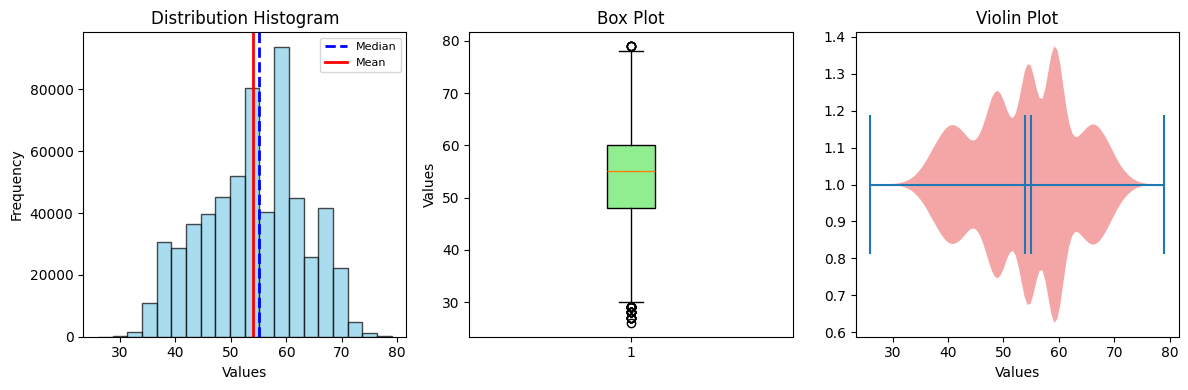


DESCRIPTIVE STATISTICS SUMMARY
count    600000.000000
mean         53.926715
std           9.091247
min          26.000000
25%          48.000000
50%          55.000000
75%          60.000000
max          79.000000
Name: age, dtype: float64

Mode(s) in the dataset: [59]
Skewness: -0.156
Kurtosis: -0.705
Missing values: 0
Total observations: 600000
----------------------------------------------------------------------------------------------------
Research analysis of resting_blood_pressure


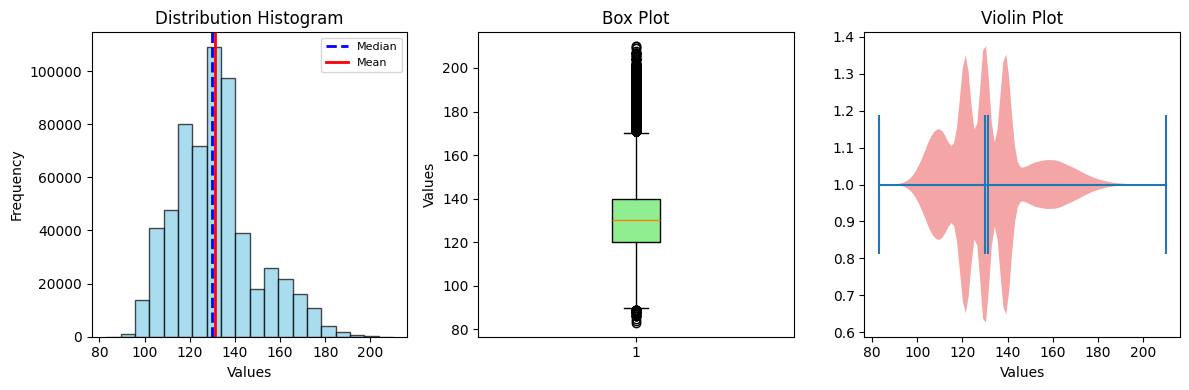


DESCRIPTIVE STATISTICS SUMMARY
count    600000.000000
mean        131.339853
std          17.844740
min          83.000000
25%         120.000000
50%         130.000000
75%         140.000000
max         210.000000
Name: resting_blood_pressure, dtype: float64

Mode(s) in the dataset: [130]
Skewness: 0.633
Kurtosis: 0.254
Missing values: 0
Total observations: 600000
----------------------------------------------------------------------------------------------------
Research analysis of maximum_heart_rate_achieved


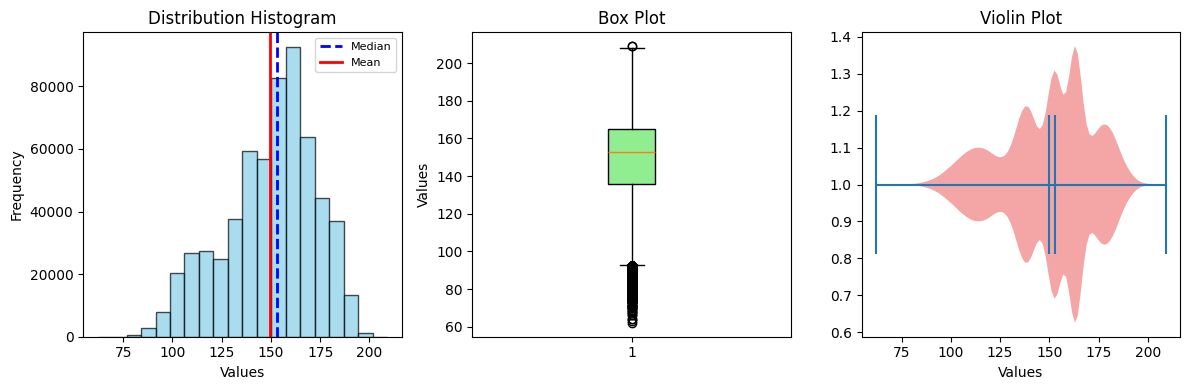


DESCRIPTIVE STATISTICS SUMMARY
count    600000.000000
mean        149.592407
std          23.073528
min          62.000000
25%         136.000000
50%         153.000000
75%         165.000000
max         209.000000
Name: maximum_heart_rate_achieved, dtype: float64

Mode(s) in the dataset: [163]
Skewness: -0.506
Kurtosis: -0.352
Missing values: 0
Total observations: 600000
----------------------------------------------------------------------------------------------------
Research analysis of serum_cholestoral


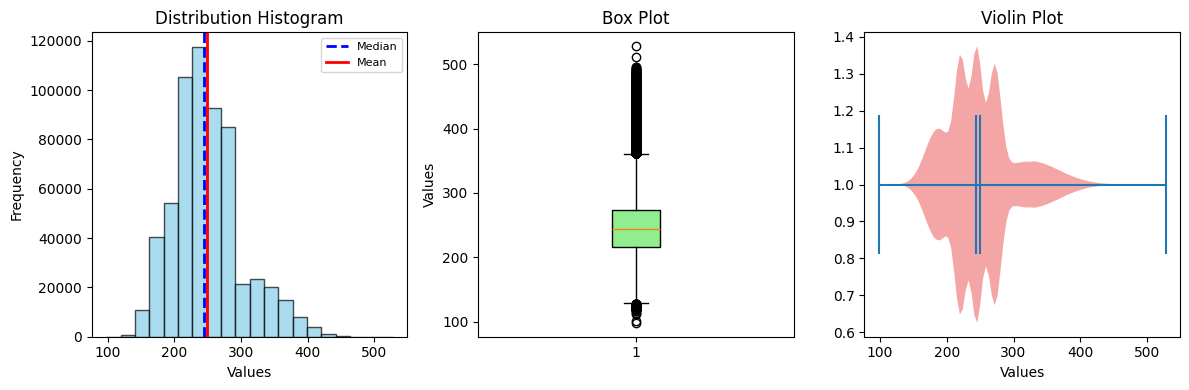


DESCRIPTIVE STATISTICS SUMMARY
count    600000.000000
mean        249.592713
std          51.700917
min          98.000000
25%         216.000000
50%         244.000000
75%         274.000000
max         528.000000
Name: serum_cholestoral, dtype: float64

Mode(s) in the dataset: [246]
Skewness: 0.764
Kurtosis: 0.759
Missing values: 0
Total observations: 600000
----------------------------------------------------------------------------------------------------
Research analysis of oldpeak


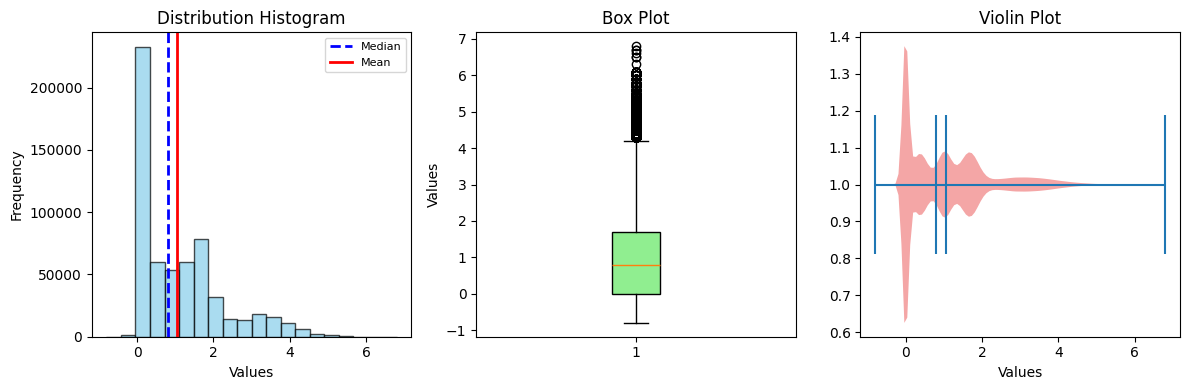


DESCRIPTIVE STATISTICS SUMMARY
count    600000.000000
mean          1.051364
std           1.144518
min          -0.800000
25%           0.000000
50%           0.800000
75%           1.700000
max           6.800000
Name: oldpeak, dtype: float64

Mode(s) in the dataset: [0.]
Skewness: 1.147
Kurtosis: 0.753
Missing values: 0
Total observations: 600000
----------------------------------------------------------------------------------------------------
Research analysis of chest


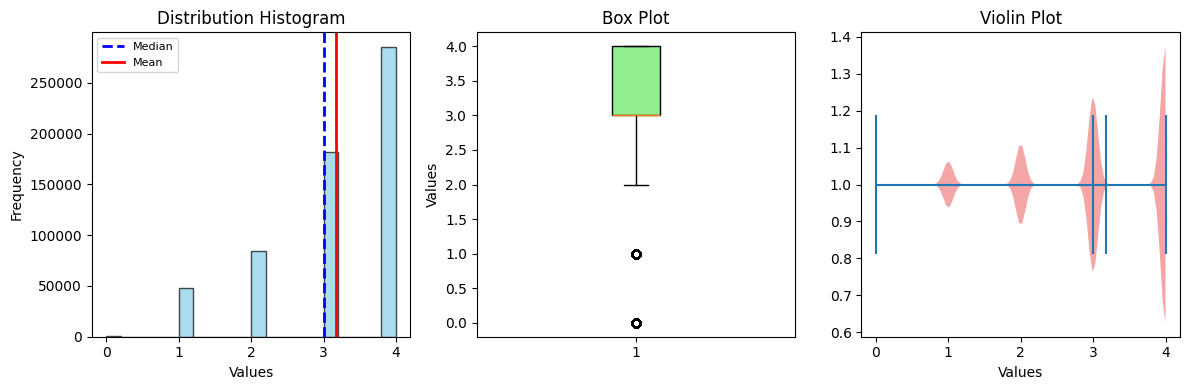


DESCRIPTIVE STATISTICS SUMMARY
count    600000.000000
mean          3.171208
std           0.958948
min           0.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: chest, dtype: float64

Mode(s) in the dataset: [4]
Skewness: -0.932
Kurtosis: -0.141
Missing values: 0
Total observations: 600000
----------------------------------------------------------------------------------------------------


In [25]:
for col in num_col:
  print(f'Research analysis of {col}')
  analysis_num(train[col])
  print('-'*100)


Research analysis of age


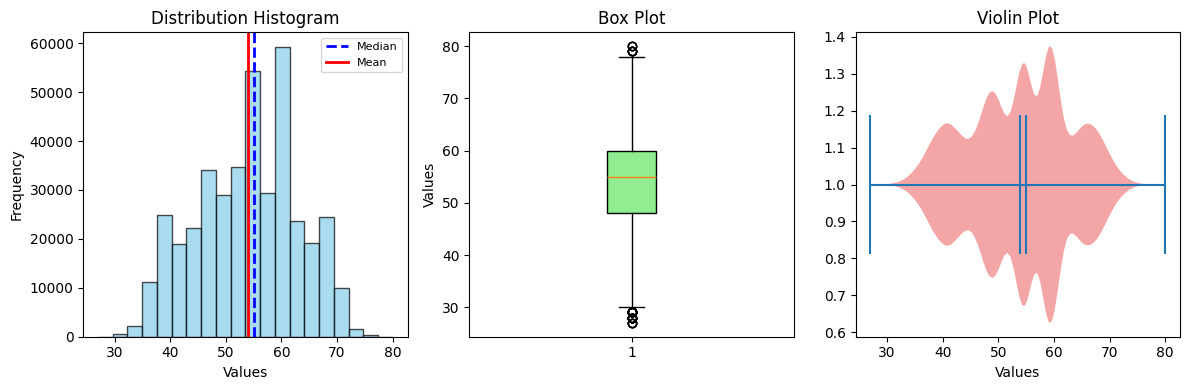


DESCRIPTIVE STATISTICS SUMMARY
count    400000.000000
mean         53.907395
std           9.105221
min          27.000000
25%          48.000000
50%          55.000000
75%          60.000000
max          80.000000
Name: age, dtype: float64

Mode(s) in the dataset: [59]
Skewness: -0.157
Kurtosis: -0.709
Missing values: 0
Total observations: 400000
----------------------------------------------------------------------------------------------------
Research analysis of resting_blood_pressure


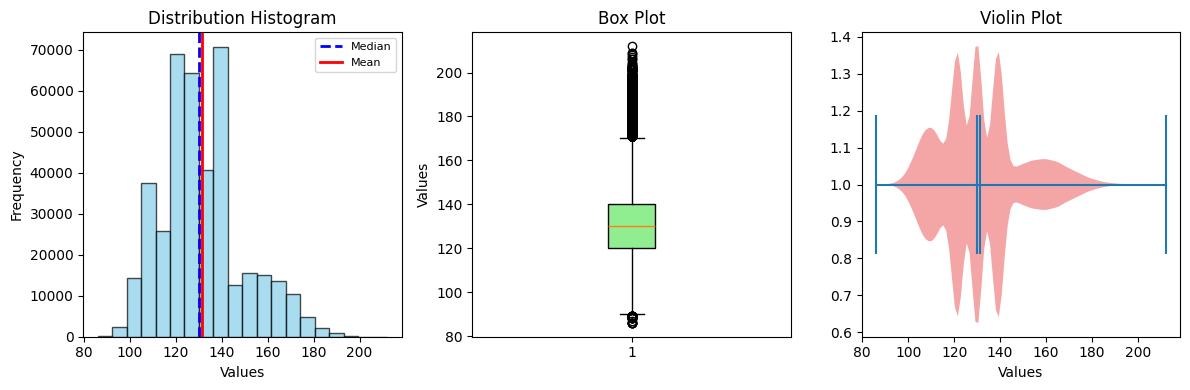


DESCRIPTIVE STATISTICS SUMMARY
count    400000.000000
mean        131.369307
std          17.864293
min          86.000000
25%         120.000000
50%         130.000000
75%         140.000000
max         212.000000
Name: resting_blood_pressure, dtype: float64

Mode(s) in the dataset: [130]
Skewness: 0.635
Kurtosis: 0.253
Missing values: 0
Total observations: 400000
----------------------------------------------------------------------------------------------------
Research analysis of maximum_heart_rate_achieved


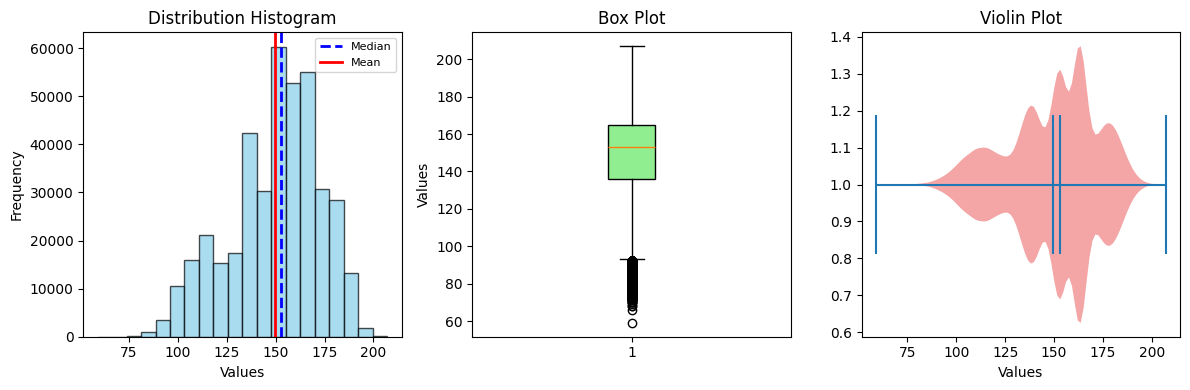


DESCRIPTIVE STATISTICS SUMMARY
count    400000.000000
mean        149.658662
std          23.067884
min          59.000000
25%         136.000000
50%         153.000000
75%         165.000000
max         207.000000
Name: maximum_heart_rate_achieved, dtype: float64

Mode(s) in the dataset: [163]
Skewness: -0.515
Kurtosis: -0.339
Missing values: 0
Total observations: 400000
----------------------------------------------------------------------------------------------------
Research analysis of serum_cholestoral


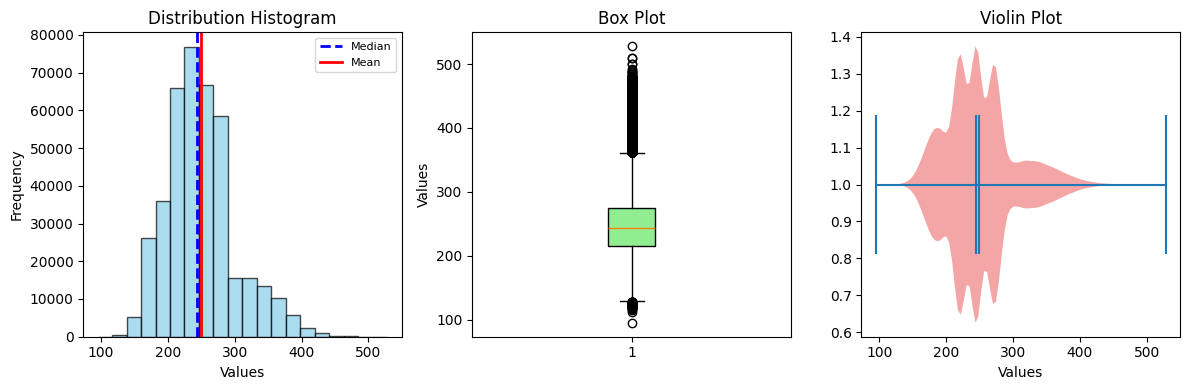


DESCRIPTIVE STATISTICS SUMMARY
count    400000.000000
mean        249.592858
std          51.721393
min          95.000000
25%         216.000000
50%         244.000000
75%         274.000000
max         528.000000
Name: serum_cholestoral, dtype: float64

Mode(s) in the dataset: [246]
Skewness: 0.763
Kurtosis: 0.761
Missing values: 0
Total observations: 400000
----------------------------------------------------------------------------------------------------
Research analysis of oldpeak


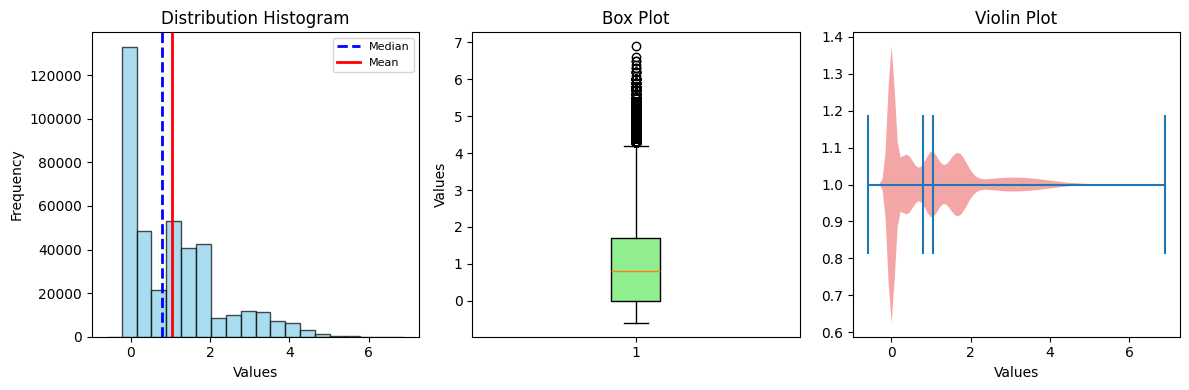


DESCRIPTIVE STATISTICS SUMMARY
count    400000.000000
mean          1.050035
std           1.141170
min          -0.600000
25%           0.000000
50%           0.800000
75%           1.700000
max           6.900000
Name: oldpeak, dtype: float64

Mode(s) in the dataset: [0.]
Skewness: 1.148
Kurtosis: 0.767
Missing values: 0
Total observations: 400000
----------------------------------------------------------------------------------------------------
Research analysis of chest


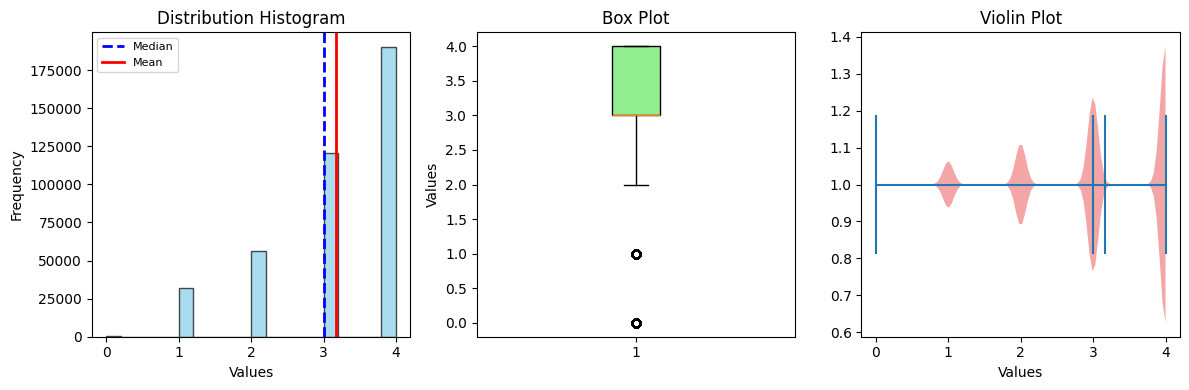


DESCRIPTIVE STATISTICS SUMMARY
count    400000.00000
mean          3.17001
std           0.95994
min           0.00000
25%           3.00000
50%           3.00000
75%           4.00000
max           4.00000
Name: chest, dtype: float64

Mode(s) in the dataset: [4]
Skewness: -0.927
Kurtosis: -0.159
Missing values: 0
Total observations: 400000
----------------------------------------------------------------------------------------------------


In [26]:
for col in num_col:
  print(f'Research analysis of {col}')
  analysis_num(test[col])
  print('-'*100)

а) **age**
- Distribution is approximately normal
- Have slight negative skew
- The mean and median are very close to each other (as seen in the histogram), indicating a symmetrical distribution with no significant skew.
- The average age of the cohort is approximately 55-60 years. Tipical age for patience with cardiovascular diseases

This is true for both datasets. The values of all parameters are within 1%, which is excellent.

b) **resting_blood_pressure**
- Distribution is normal, but with middle right skew
- The mean and median are very close to each other (as seen in the histogram), indicating a symmetrical distribution with no significant skew.
- There is a big spread, but kurtosis is very close to 0.

This is true for both datasets. The values of all parameters are within 1%, which is excellent.

c) **maximum_heart_rate_achieved**
- The mean and median are very close to each other (as seen in the histogram), indicating a symmetrical distribution with no significant skew
- We see left-skewed asymmetry - more patients achieve relatively high heart rate values

This is true for both datasets. The values of all parameters are within 1%, which is excellent.

d) **serum_cholestoral**
- Majority of values concentrated on the left side (lower cholesterol)
- istribution has slightly heavier tails than normal

Data needs to be transformed and standardized.
Again, the data is perfectly divided. The metrics and graphs in the training and test data sets are almost identical.

e) **oldpeak**
- most common value is normal. There are too many normal values, it can overtrain the model
- strong right-skewed distribution

It can be seen that this indicator is very important for finding pathology, as it is typical for disease markers, where most of them are normal, a few are severe, where there is a large tail towards pathology.
Data needs to be transformed and standardized.

f) **chest**
*value 1, value 2, value 3, and value 4, referring to atypical angina, typical angina, asymptomatic and non-anginal pain, respectively*
- Concentration on higher values (3 and 4)
- Asymmetric distribution
- The skewness toward higher values indicates nonormal destribution

Chest pain type is a cornerstone of cardiac assessment and will likely be one of the most important predictors in my model.
Data needs to be transformed and standardized

*Conclusion:* some of the data needs to be normalized, but the rest is suspiciously fine.

 Research analysis sex


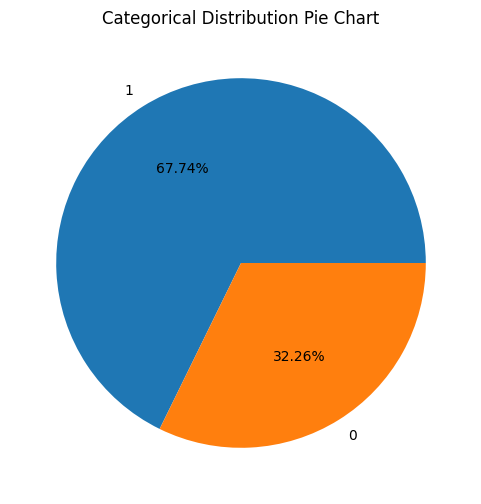

----------------------------------------------------------------------------------------------------
 Research analysis fasting_blood_sugar


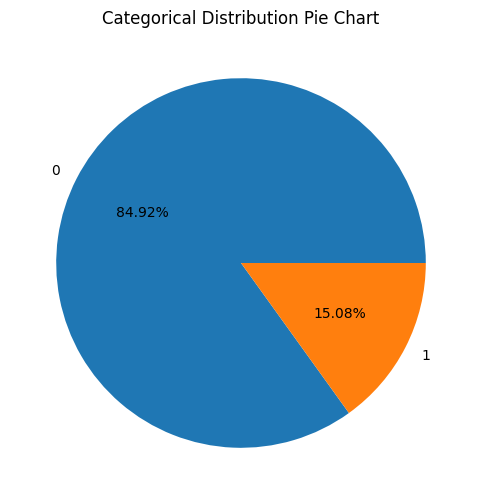

----------------------------------------------------------------------------------------------------
 Research analysis exercise_induced_angina


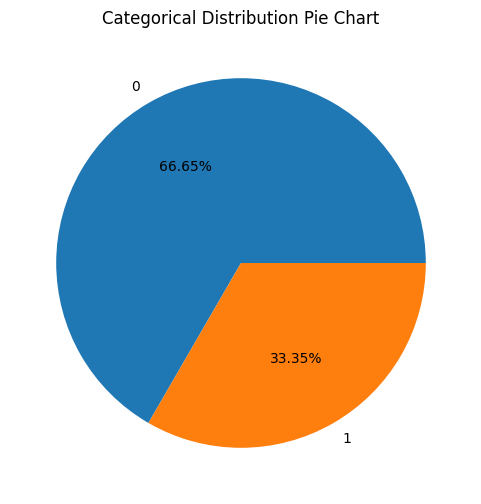

----------------------------------------------------------------------------------------------------
 Research analysis class


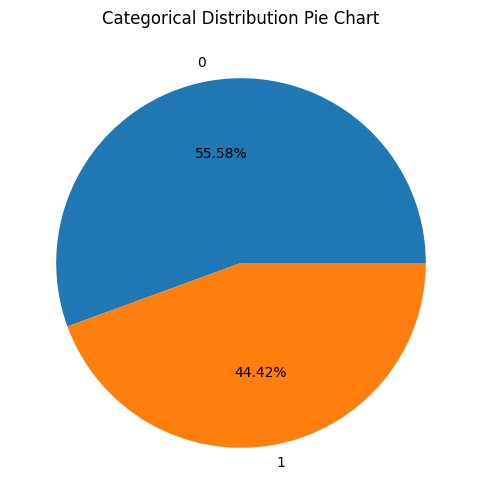

----------------------------------------------------------------------------------------------------


In [27]:
for col in bool_col:
  print(f' Research analysis {col}')
  analysis_cat_pie(train[col])
  print('-'*100)

 Research analysis sex


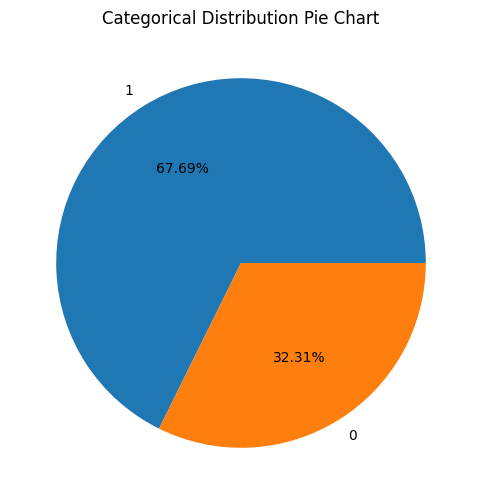

----------------------------------------------------------------------------------------------------
 Research analysis fasting_blood_sugar


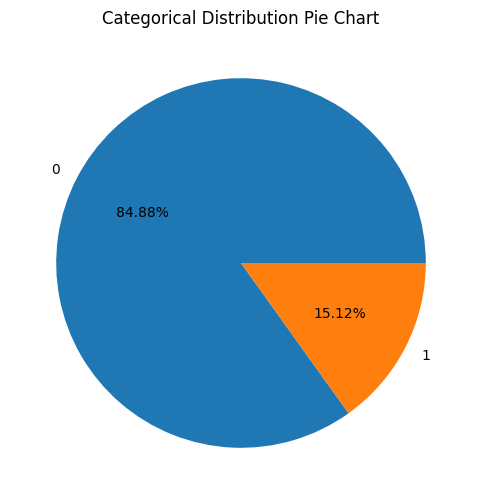

----------------------------------------------------------------------------------------------------
 Research analysis exercise_induced_angina


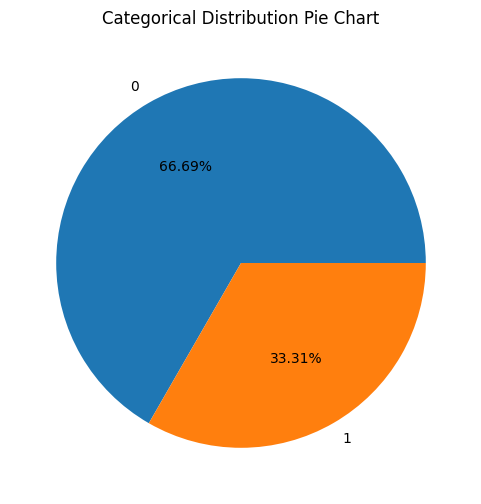

----------------------------------------------------------------------------------------------------
 Research analysis class


KeyError: 'class'

In [28]:
for col in bool_col:
  print(f' Research analysis {col}')
  analysis_cat_pie(test[col])
  print('-'*100)

a) **sex**
*0 indicates female and 1 refers to male*
- There are more men in both the train and test samples.

b) **fasting_blood_sugar**
*= 1 if > 120 mg\dl*
- Indicates that a minority (15%) have insulin resistance

c) **exercise-induced angina**
- and again, the shift towards the asymptomatic

e) **class**
- The split between sick and healthy subjects in the train set is approximately equal, with a slight bias toward healthy subjects.
- The test set lacks this target feature - class. Based on the excellent data split, with very similar statistical indicators, we will achieve approximately the same ratio in the training set - 55/45.

 Research analysis resting_electrocardiographic_results


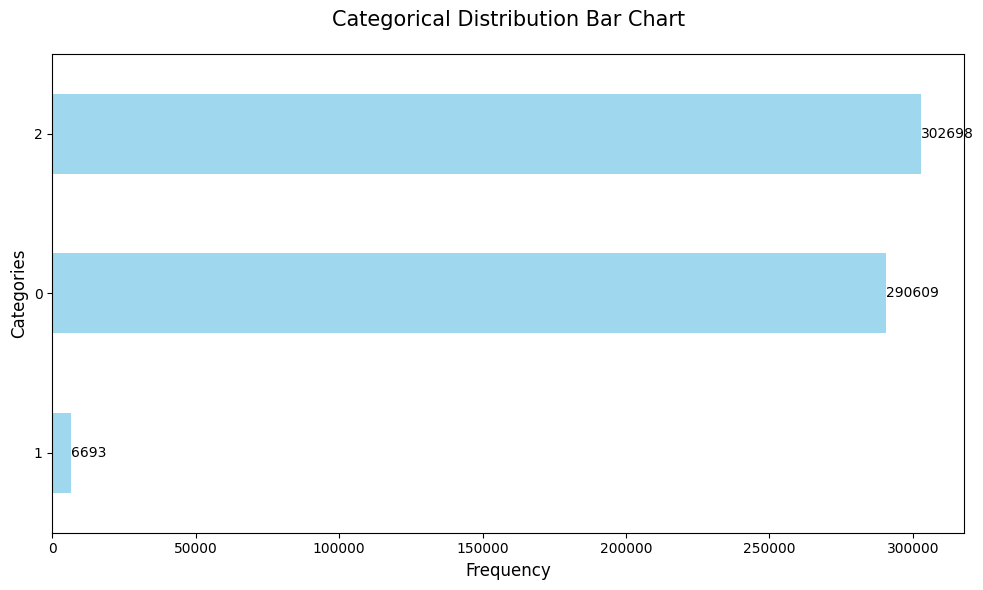

Total categories: 3
Total observations: 600000
Most frequent category: '2' (302698 occurrences)
Least frequent category: '1' (6693 occurrences)
----------------------------------------------------------------------------------------------------
 Research analysis slope


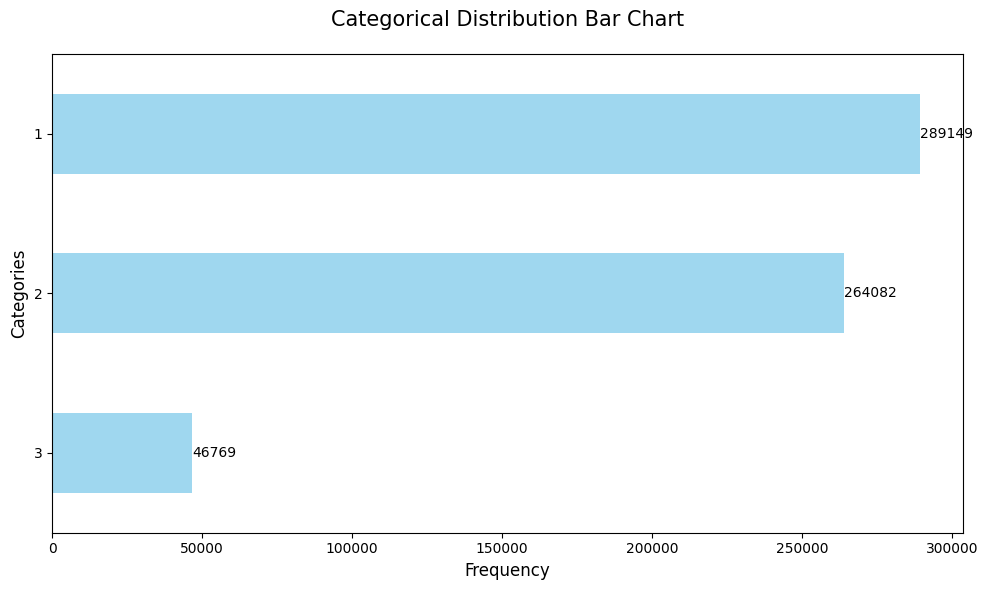

Total categories: 3
Total observations: 600000
Most frequent category: '1' (289149 occurrences)
Least frequent category: '3' (46769 occurrences)
----------------------------------------------------------------------------------------------------
 Research analysis number_of_major_vessels


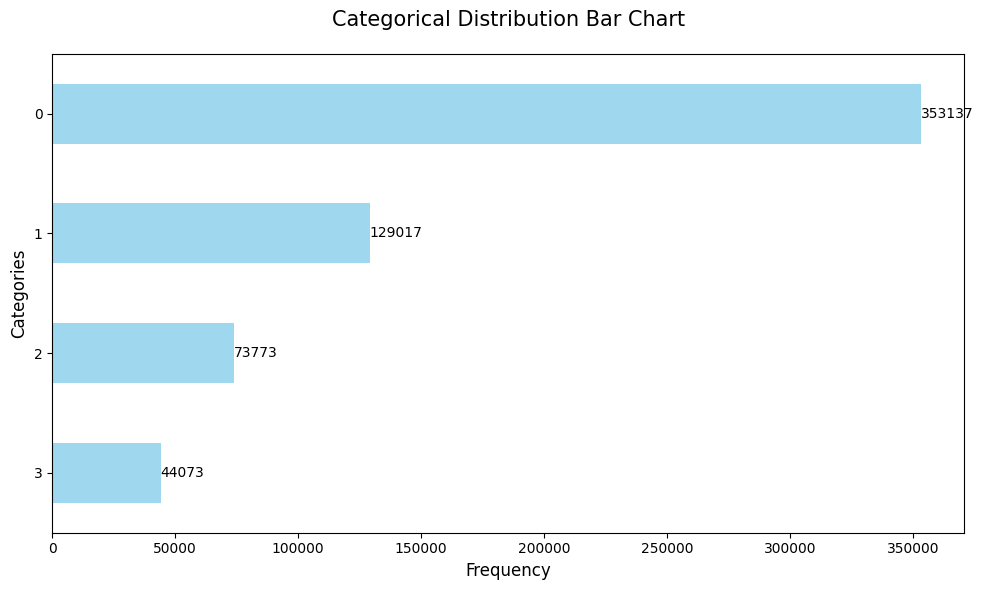

Total categories: 4
Total observations: 600000
Most frequent category: '0' (353137 occurrences)
Least frequent category: '3' (44073 occurrences)
----------------------------------------------------------------------------------------------------
 Research analysis thal


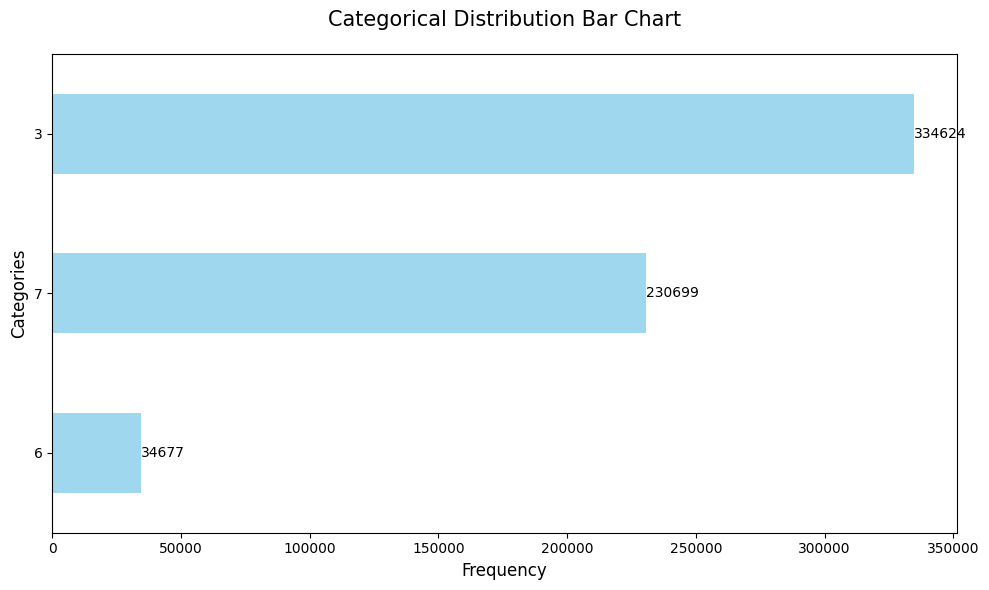

Total categories: 3
Total observations: 600000
Most frequent category: '3' (334624 occurrences)
Least frequent category: '6' (34677 occurrences)
----------------------------------------------------------------------------------------------------


In [30]:
for col in cat_col:
  print(f' Research analysis {col}')
  analysis_cat_plot(train[col])
  print('-'*100)

 Research analysis resting_electrocardiographic_results


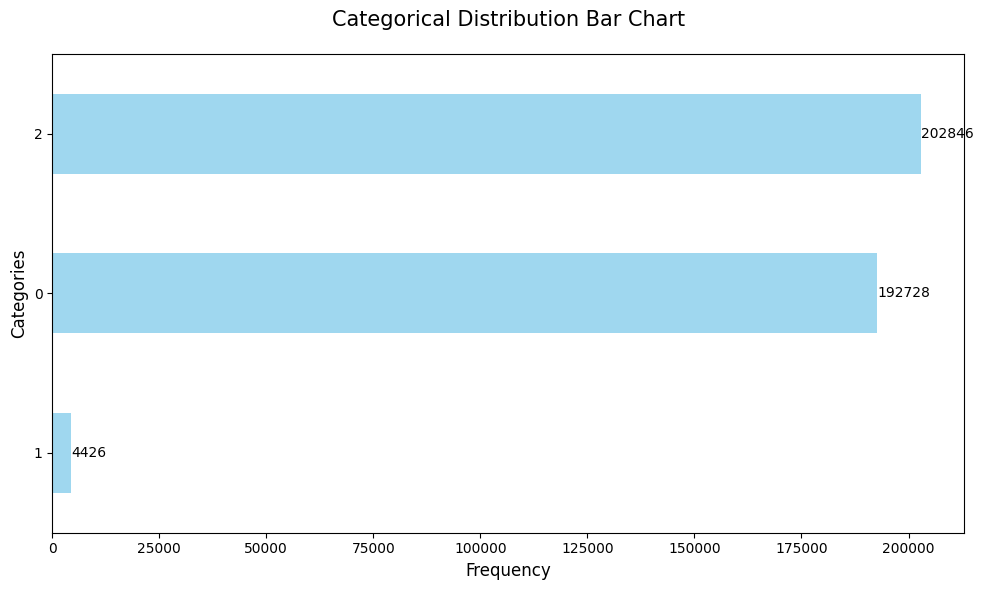

Total categories: 3
Total observations: 400000
Most frequent category: '2' (202846 occurrences)
Least frequent category: '1' (4426 occurrences)
----------------------------------------------------------------------------------------------------
 Research analysis slope


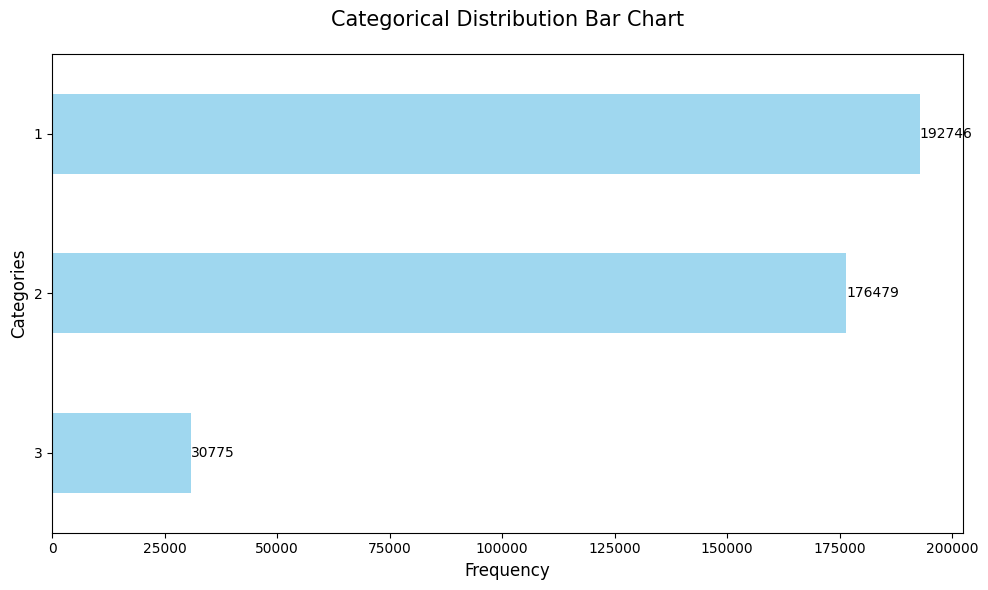

Total categories: 3
Total observations: 400000
Most frequent category: '1' (192746 occurrences)
Least frequent category: '3' (30775 occurrences)
----------------------------------------------------------------------------------------------------
 Research analysis number_of_major_vessels


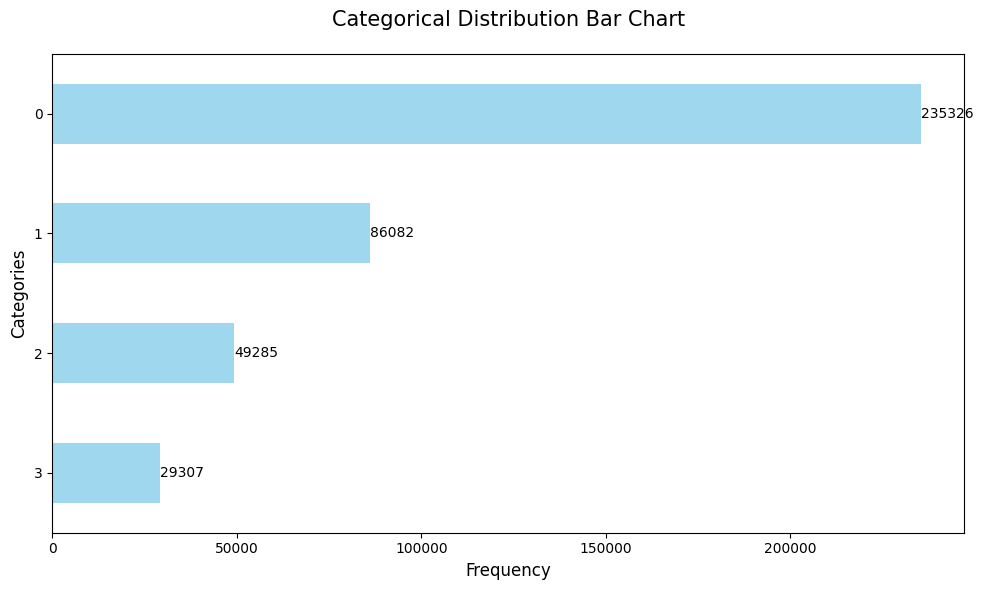

Total categories: 4
Total observations: 400000
Most frequent category: '0' (235326 occurrences)
Least frequent category: '3' (29307 occurrences)
----------------------------------------------------------------------------------------------------
 Research analysis thal


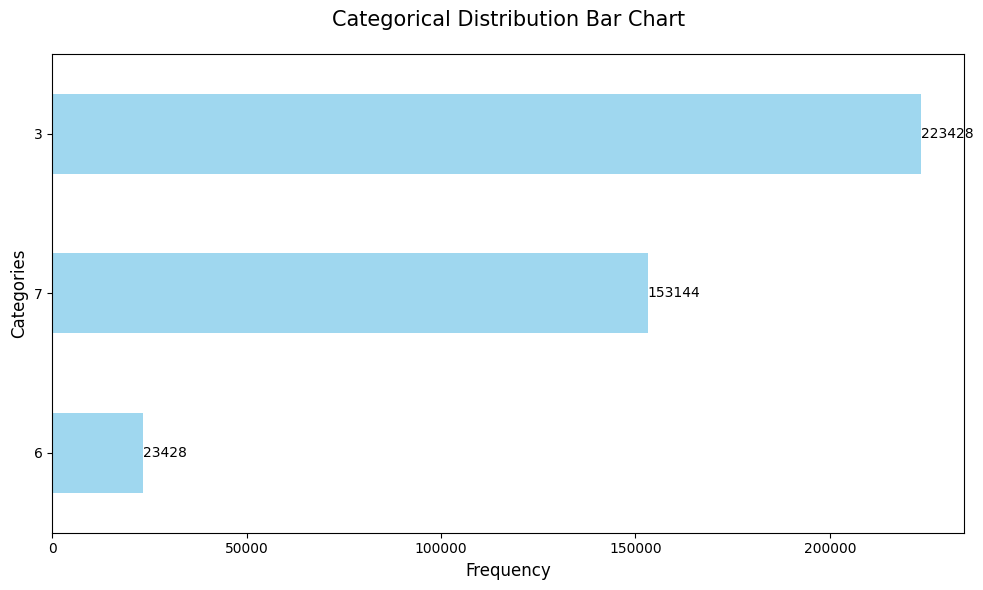

Total categories: 3
Total observations: 400000
Most frequent category: '3' (223428 occurrences)
Least frequent category: '6' (23428 occurrences)
----------------------------------------------------------------------------------------------------


In [31]:
for col in cat_col:
  print(f' Research analysis {col}')
  analysis_cat_plot(test[col])
  print('-'*100)

a) **resting_electrocardiographic_results**
*0 - no abnormalities detected, 1 - left ventricular hypertrophy, 2 - possible presence of ischemia.*

b) **slope**
*1 - segment elevation, 2 - segment horizontal position, 3 - segment lowering.1 - segment elevation, 2 - segment horizontal position, 3 - segment lowering.*

c) **number_of_major_vessels**
*0 = No significant coronary artery disease
1 = Single-vessel disease
2 = Double-vessel disease
3 = Triple-vessel disease*

d) **thal**
*3 = normal; 6 = fixed defect; 7 = reversable defect*

*Сonclusion:* It is expected that most patients have no signs of the disease, while most of them have a possible presence of ischemia. It was the first suspicion of ischemia that led them to the doctors.



## 3. Сorrelation analysis
_____________________________________

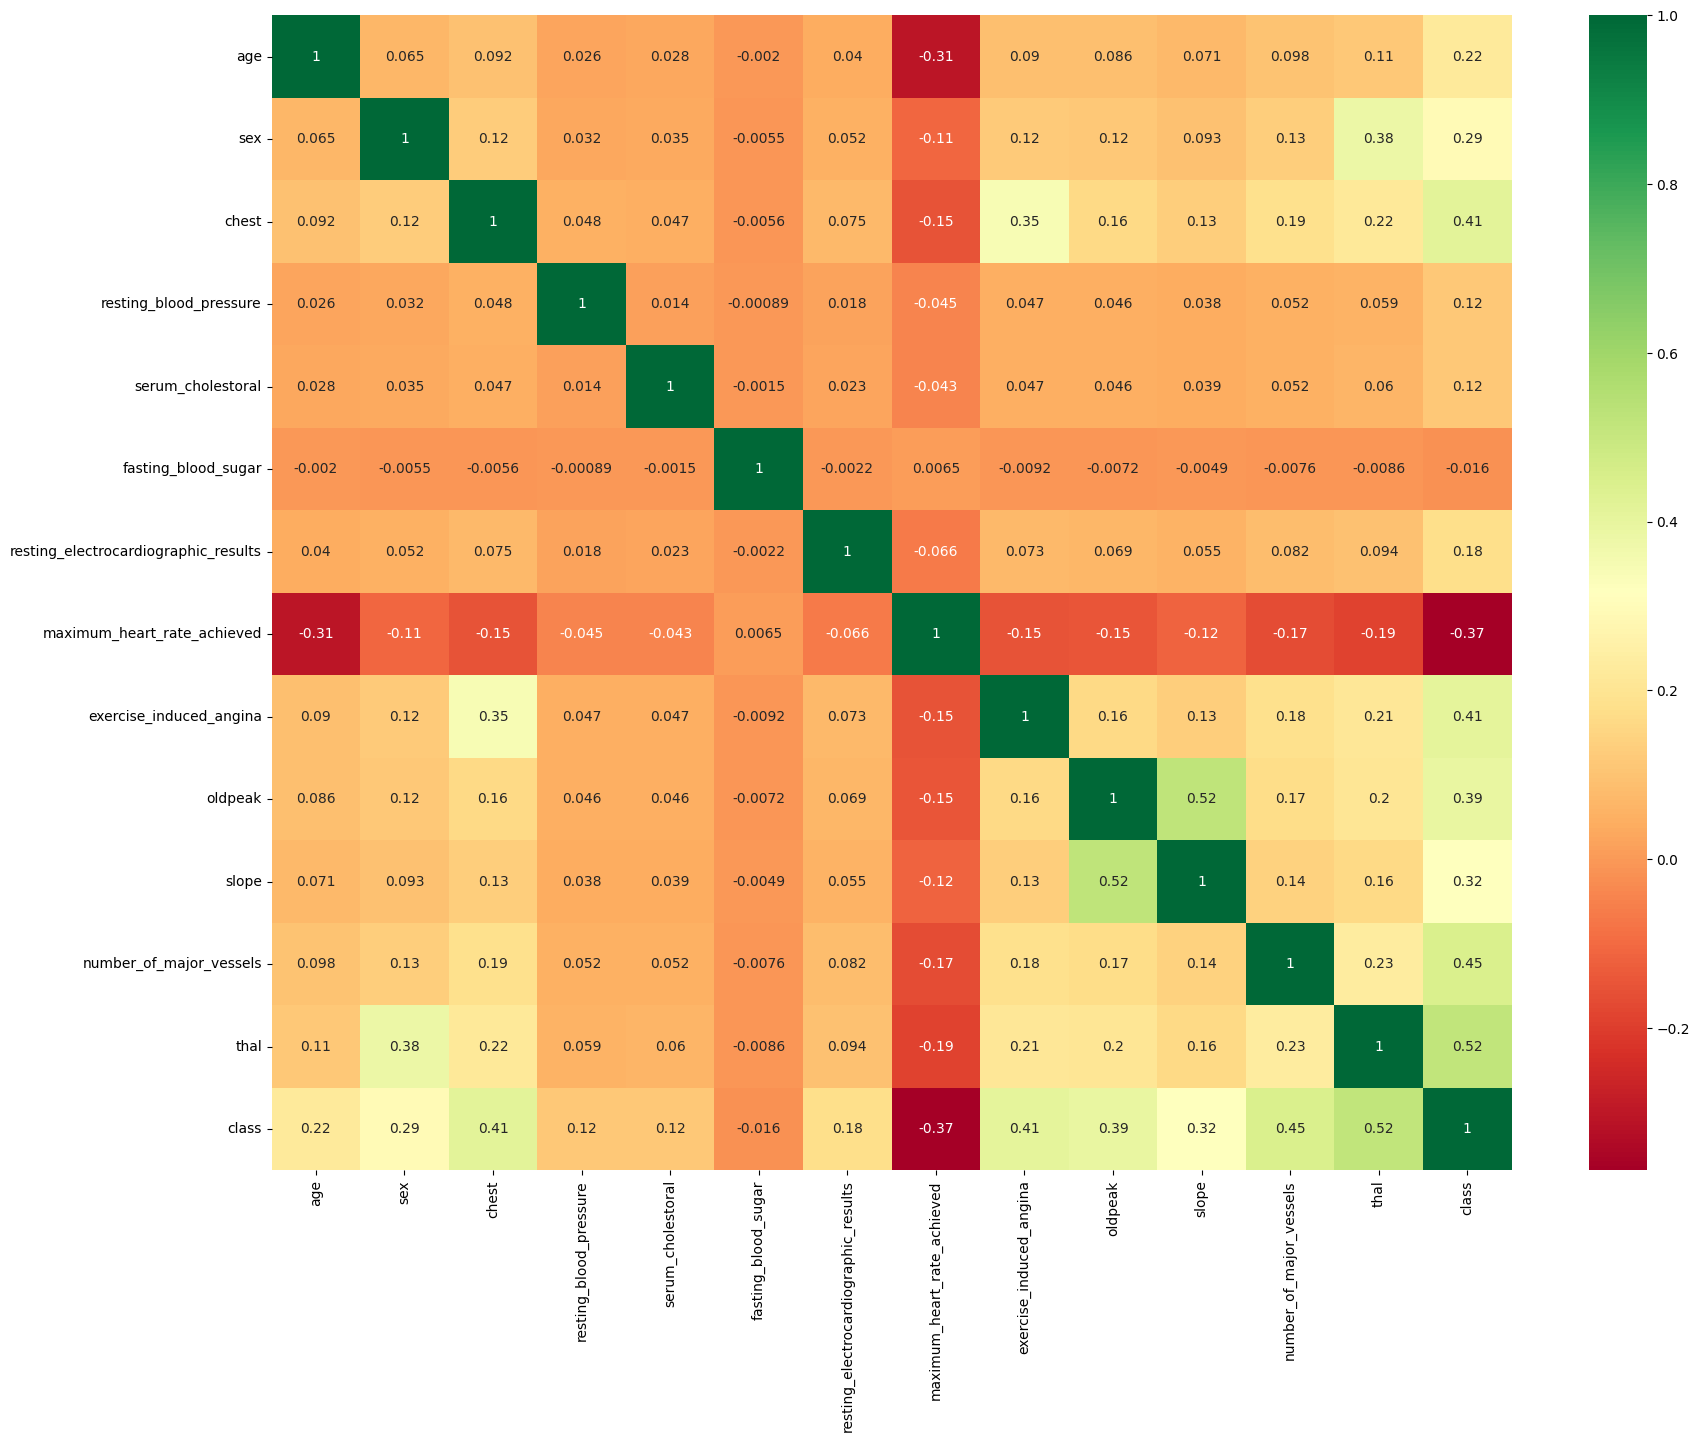

In [32]:
corr_matrix_df = train.drop('ID', axis = 1).corr()

rank = np.linalg.matrix_rank(corr_matrix_df.values)
determinant = np.linalg.det(corr_matrix_df.values)

fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix_df, annot=True, cmap='RdYlGn')
plt.show()


**Strong** and logic, since the following indicators confirm the diagnosis
- thai (0.52)
- number_of_major_vessels (0.45)

**Strong** from the symptoms
- сhest pain (0.41)
- exercise_induced_angina (0.41)
- oldpeak (0.39)

**Moderate Predictors**
- maximum_heart_rate_achieved (-0.37) *the lower the result, the worse the heart works.*
- slope (0.32)
- sex (0.29)
- age (0.22)

**Interesting correlations between categories**
- oldpeak & slope (0.52) - *these indicators are taken simultaneously and under the same conditions, showing similar parameters*
- thai & sex (0.38) - *this correlation supports the found correlation of age and morbidity by 0.29*
- chest & exercise_induced_angina (0.35) - *They are associated with disorders in the lungs and heart, and one causes the other*
- thai & number_of_major_vessels (0.23) - *an interesting observation, it draws on a separate practical study*
- age & maximum_heart_rate_achieved (-0.31) - *as expected*
-



# III. Machine learning
______________________________________

1)  Preparing data for a machine learning classification task

In [33]:
# separating features from target
y_train = train['class']
X_train = train.drop(['ID', 'class'], axis = 1)

test = test.drop('ID', axis = 1)

In [34]:
# standardizing numerical features
scaler = StandardScaler()\

scale = ['age', 'resting_blood_pressure','serum_cholestoral','maximum_heart_rate_achieved', 'oldpeak']
nonscale = ['sex', 'chest','fasting_blood_sugar','resting_electrocardiographic_results', 'exercise_induced_angina', 'slope', 'number_of_major_vessels', 'thal']

Data splitting

In [35]:
X_train_scaler = scaler.fit_transform(X_train[scale])
test_scaler = scaler.transform(test[scale])

In [36]:
X_train_scaler = pd.DataFrame(X_train_scaler, index=X_train.index, columns=scale)
test_scaler = pd.DataFrame(test_scaler, index=test.index, columns=scale)

In [37]:
X_train = pd.concat([X_train_scaler, X_train[nonscale]], axis=1)
test = pd.concat([test_scaler, test[nonscale]], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20,
                                                    random_state= 42, stratify=y_train)

2. SMOTE for problematic classes

In [43]:
#imbalanced_targets = ['oldpeak','chest', 'sex', 'fasting_blood_sugar','exercise_induced_angina','resting_electrocardiographic_results','slope','number_of_major_vessels','thal']]
#rain_smote, y_train_smote = apply_smote_only(imbalanced_targets, X_train, y_train)

3. Machine learning
________________________________________
LogisticRegression

ROC-AUC Evaluation on Test Data
ROC-AUC Score on Test Data: 0.9481


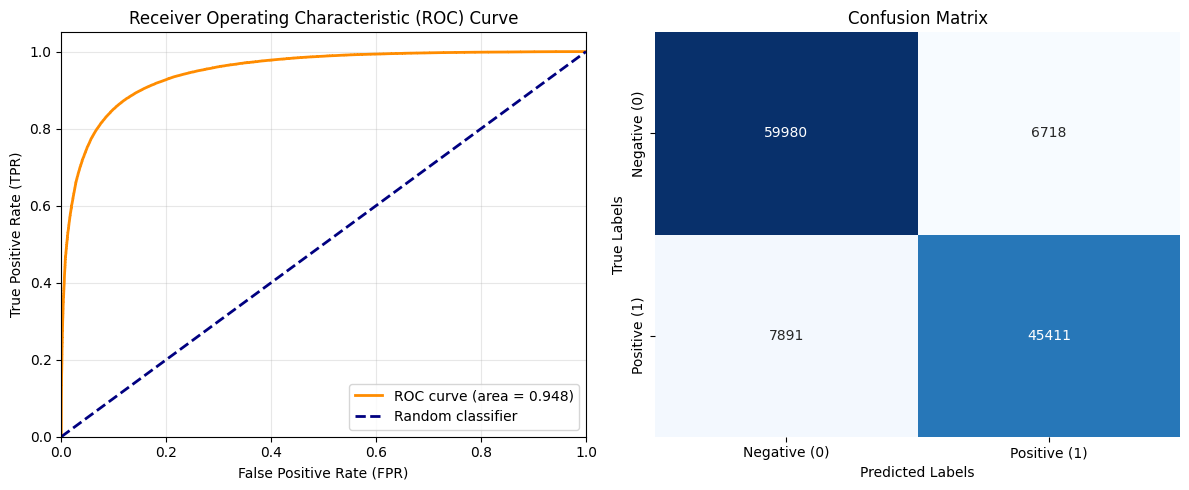


Detailed Performance Metrics:
----------------------------------------
Accuracy:  0.8783
Precision: 0.8711
Recall:    0.8520
F1-Score:  0.8614
ROC-AUC:   0.9481

ROC-AUC Interpretation:
----------------------------------------
Excellent discrimination (AUC = 0.948)

Confusion Matrix Breakdown:
----------------------------------------
True Negatives:  59980
False Positives: 6718
False Negatives: 7891
True Positives:  45411
Sensitivity (Recall): 0.852
Specificity: 0.899


{'roc_auc': np.float64(0.9480976174510052),
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99692644, 0.99692644,
        1.        ]),
 'tpr': array([0.00000000e+00, 1.87610221e-05, 4.91538779e-02, ...,
        9.99981239e-01, 1.00000000e+00, 1.00000000e+00]),
 'thresholds': array([           inf, 9.99970597e-01, 9.97978224e-01, ...,
        7.06020416e-04, 7.04390055e-04, 1.97656432e-04]),
 'confusion_matrix': array([[59980,  6718],
        [ 7891, 45411]]),
 'predictions': array([1, 0, 0, ..., 0, 0, 1]),
 'accuracy': 0.8782583333333334,
 'precision': 0.8711273954996259,
 'recall': 0.8519567746050805,
 'f1_score': 0.8614354411890242}

In [45]:
easy_lr = LogisticRegression(random_state=42)
easy_lr.fit(X_train, y_train)
y_pred_lr = easy_lr.predict(X_val)
accuracy_lr = round(accuracy_score(y_val, y_pred_lr), 4)

evaluate_model(easy_lr, X_val, y_val)

Let's find better parameters by Random Search CV

In [60]:
lr = LogisticRegression(max_iter=1000, random_state=42)


param_lr = {
    'C': uniform(loc=0.001, scale=100),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'class_weight': [None, 'balanced']
}


random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_lr,
    n_iter= 50,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42 )

random_search_lr.fit(X_train, y_train)
lr_best = random_search_lr.best_estimator_
best_score_lr = round(random_search_lr.best_score_, 4)

print('Best model and its parameters:\n\n', lr_best)
print('Best model parameters:\n', random_search_lr.best_params_)
print(f'\n\nCorrectness metric on the cross-validation set:', best_score_lr)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
87 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

Best model and its parameters:

 LogisticRegression(C=np.float64(25.6078322761324), max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')
Best model parameters:
 {'C': np.float64(25.6078322761324), 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


Correctness metric on the cross-validation set: 0.879


In [61]:
y_pred_lr_s = lr_best.predict(X_val)
accuracy_lr_s = accuracy_score(y_val, y_pred_lr_s)

ROC-AUC Evaluation on Test Data
ROC-AUC Score on Test Data: 0.9481


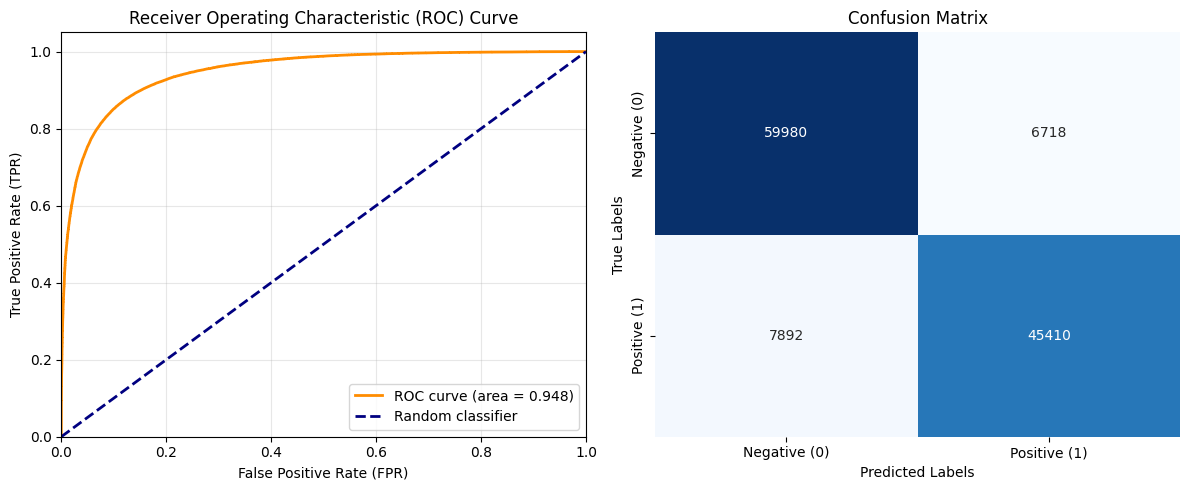


Detailed Performance Metrics:
----------------------------------------
Accuracy:  0.8782
Precision: 0.8711
Recall:    0.8519
F1-Score:  0.8614
ROC-AUC:   0.9481

ROC-AUC Interpretation:
----------------------------------------
Excellent discrimination (AUC = 0.948)

Confusion Matrix Breakdown:
----------------------------------------
True Negatives:  59980
False Positives: 6718
False Negatives: 7892
True Positives:  45410
Sensitivity (Recall): 0.852
Specificity: 0.899


{'roc_auc': np.float64(0.9480977625930995),
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99692644, 0.99692644,
        1.        ]),
 'tpr': array([0.00000000e+00, 1.87610221e-05, 4.91726389e-02, ...,
        9.99981239e-01, 1.00000000e+00, 1.00000000e+00]),
 'thresholds': array([           inf, 9.99970533e-01, 9.97973409e-01, ...,
        7.09922478e-04, 7.08627580e-04, 1.98810540e-04]),
 'confusion_matrix': array([[59980,  6718],
        [ 7892, 45410]]),
 'predictions': array([1, 0, 0, ..., 0, 0, 1]),
 'accuracy': 0.87825,
 'precision': 0.8711249232658073,
 'recall': 0.85193801358298,
 'f1_score': 0.8614246419425211}

In [62]:
evaluate_model(lr_best, X_val, y_val)

Nothing changed :)
Anyway the result is good.

RandomForest

ROC-AUC Evaluation on Test Data
ROC-AUC Score on Test Data: 0.9596


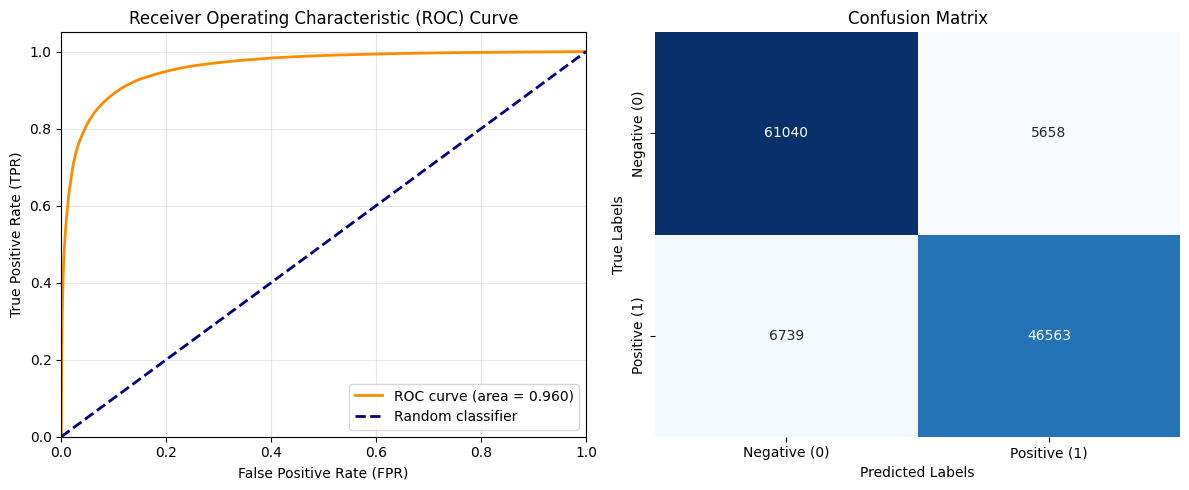


Detailed Performance Metrics:
----------------------------------------
Accuracy:  0.8967
Precision: 0.8917
Recall:    0.8736
F1-Score:  0.8825
ROC-AUC:   0.9596

ROC-AUC Interpretation:
----------------------------------------
Excellent discrimination (AUC = 0.960)

Confusion Matrix Breakdown:
----------------------------------------
True Negatives:  61040
False Positives: 5658
False Negatives: 6739
True Positives:  46563
Sensitivity (Recall): 0.874
Specificity: 0.915


{'roc_auc': np.float64(0.9596391764273479),
 'fpr': array([0.00000000e+00, 9.14570152e-04, 1.76916849e-03, 2.77369636e-03,
        3.76323128e-03, 4.76775915e-03, 6.01217428e-03, 7.43650484e-03,
        8.54598339e-03, 9.85037033e-03, 1.11997361e-02, 1.24891301e-02,
        1.35536298e-02, 1.48280308e-02, 1.61324178e-02, 1.76467060e-02,
        1.88011635e-02, 2.01205433e-02, 2.14399232e-02, 2.26843384e-02,
        2.40337042e-02, 2.55779784e-02, 2.68823653e-02, 2.81717593e-02,
        2.99709137e-02, 3.17100963e-02, 3.30894480e-02, 3.48586165e-02,
        3.68376863e-02, 3.88617350e-02, 4.06758823e-02, 4.25649945e-02,
        4.44990854e-02, 4.61633032e-02, 4.77825422e-02, 4.97316261e-02,
        5.17856607e-02, 5.35998081e-02, 5.57887793e-02, 5.79177786e-02,
        6.01517287e-02, 6.20858197e-02, 6.44247204e-02, 6.71234520e-02,
        6.91924795e-02, 7.17112957e-02, 7.42900837e-02, 7.68238928e-02,
        7.91927794e-02, 8.20414405e-02, 8.48301298e-02, 8.77237698e-02,
        9.063

In [63]:
easy_forest = RandomForestClassifier()

easy_forest.fit(X_train, y_train)

y_pred_f= easy_forest.predict(X_val)
accuracy_f= accuracy_score(y_val, y_pred_f)
evaluate_model(easy_forest, X_val, y_val)

In [ ]:
forest = RandomForestClassifier()

forest_param = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'bootstrap': [True, False]
}

random_search_forest = RandomizedSearchCV(
    estimator=forest,
    param_distributions=forest_param,
    n_iter=3,
    cv=2,
    scoring='accuracy')

random_search_forest.fit(X_train, y_train)

forest_best = random_search_forest.best_estimator_
best_score_forest = round(random_search_forest.best_score_, 4)

print('Best model and its parameters:\n\n', lr_best)
print('Best model parameters:\n', random_search_lr.best_params_)
print(f'\n\nCorrectness metric on the cross-validation set:', best_score_lr)


Neural Network

In [ ]:
# bilding
model = Sequential([
    Dense(128, input_shape=X_train.shape[1:], activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax'),
    Dense(1, activation='sigmoid')
])

#compilation
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=5,
                    validation_data=(X_val, y_val),
                    batch_size= 32)

max_accuracy = max(history.history['accuracy'])

In [ ]:
# Let's choose best one
models = ['easy_lr', 'lr',
          'easy_forest', 'forest',
          'model']
metrics = {'accuracy' : [accuracy_lr, best_score_lr,
                         accuracy_f, best_score_forest,
                         max_accuracy]}

b_m = pd.DataFrame(metrics, index=models)

# heat map
plt.figure(figsize=(8, 6))
sns.heatmap(b_m, annot=True, fmt='.2f', cmap='YlGnBu', cbar=True)
plt.title('Heat map')
plt.xlabel('Меtrix')
plt.ylabel('Models')
plt.show()

# 4. Conclusion
______________________________
As you can see, with cross-validation and validation data, we get accuracy metrics of more than 0.85. But with a detailed study of accuracy metrics, ROC-AUC and the error matrix, there is an assumption about retraining the model. This is a consequence of the absolute repetition of the indicators of the test and training samples.
Since the target features have not been transmitted within the framework of the test data, we cannot draw complete conclusions about the models.